In [67]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType
from pyspark.sql.functions import isnull, isnan, sum, count, col, when,to_date, unix_timestamp

In [68]:
# initializing a spark session with weekly_sales appname 
spark = SparkSession.builder.appName("weekly_sales").getOrCreate()

In [69]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["Walmart"]
collection = db["weekly_sales"]
rows = collection.find()
list(rows)

[{'_id': ObjectId('6449131a402f537501ac6ed1'),
  'Store': 1,
  'Date': '19-02-2010',
  'Weekly_Sales': 1611968.17,
  'Holiday_Flag': 0,
  'Temperature': 39.93,
  'Fuel_Price': 2.514,
  'CPI': 211.2891429,
  'Unemployment': 8.106},
 {'_id': ObjectId('6449131a402f537501ac6ed2'),
  'Store': 1,
  'Date': '05-03-2010',
  'Weekly_Sales': 1554806.68,
  'Holiday_Flag': 0,
  'Temperature': 46.5,
  'Fuel_Price': 2.625,
  'CPI': 211.3501429,
  'Unemployment': 8.106},
 {'_id': ObjectId('6449131a402f537501ac6ed3'),
  'Store': 1,
  'Date': '12-02-2010',
  'Weekly_Sales': 1641957.44,
  'Holiday_Flag': 1,
  'Temperature': 38.51,
  'Fuel_Price': 2.548,
  'CPI': 211.2421698,
  'Unemployment': 8.106},
 {'_id': ObjectId('6449131a402f537501ac6ed4'),
  'Store': 1,
  'Date': '12-03-2010',
  'Weekly_Sales': 1439541.59,
  'Holiday_Flag': 0,
  'Temperature': 57.79,
  'Fuel_Price': 2.667,
  'CPI': 211.3806429,
  'Unemployment': 8.106},
 {'_id': ObjectId('6449131a402f537501ac6ed5'),
  'Store': 1,
  'Date': '19-03

In [70]:
#creating structure for sparkDatatype
schema = StructType(
    [
        StructField("Store", StringType(), True),
        StructField("Date", StringType(), True),
        StructField("Weekly_Sales", StringType(), True),
        StructField("Holiday_Flag", StringType(), True),
        StructField("Temperature", StringType(), True),
        StructField("Fuel_Price", StringType(), True),
        StructField("CPI", StringType(), True),
        StructField("Unemployment", StringType(), True),
    ])

In [71]:
# creating a spark dataframe
df = spark.createDataFrame(rows, schema)
df.printSchema()

root
 |-- Store: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Weekly_Sales: string (nullable = true)
 |-- Holiday_Flag: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Fuel_Price: string (nullable = true)
 |-- CPI: string (nullable = true)
 |-- Unemployment: string (nullable = true)



In [72]:
df.columns

['Store',
 'Date',
 'Weekly_Sales',
 'Holiday_Flag',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment']

In [73]:
#converting raw data obtained from mongodb into pandas dataframe
rows = collection.find()
df = pd.DataFrame(list(rows))

In [74]:
df.shape

(6435, 9)

In [75]:
df

,_id,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6449131a402f537501ac6ed1,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
1,6449131a402f537501ac6ed2,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
2,6449131a402f537501ac6ed3,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
3,6449131a402f537501ac6ed4,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
4,6449131a402f537501ac6ed5,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
...,...,...,...,...,...,...,...,...,...
6430,6449131a402f537501ac87ef,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,6449131a402f537501ac87f0,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,6449131a402f537501ac87f1,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,6449131a402f537501ac87f2,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [76]:
df = df.drop(["_id"], axis="columns")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
1,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
2,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
3,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
4,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106


### Understanding the Data

<div style="text-align: justify">The above dataset is the historical data of Walmart that cover the sales from 2010/02/05 to 2012/11/01. The main objective of the dataset is to find the sales including the economic factors like CPI(Consumer Price Index), Unemployment Index, Fuel Price etc.</div><br>

<div style="text-align: justify">The dataset contains 7 columns where Store is the nukmber of store, Date is the week sale data, Weekly_Sales is the sales for the given store, Holiday_Flag whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week, Temperature is the temperature of the day of the sales, Fuel Price which is the price of the fuel in that region, CPI is the consumer price index, Unemployment is the prevailing unemployment rate</div>

In [77]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [78]:
print("Total Columns {}".format(len(df.columns)))

Total Columns 8


In [79]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [80]:
# checking for null values in the dataframe
df.isna().sum() + df.eq('NULL').sum() + df.eq('').sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

## Data PreProcessing

In [81]:
df.head

<bound method NDFrame.head of       Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1  19-02-2010    1611968.17             0        39.93       2.514   
1         1  05-03-2010    1554806.68             0        46.50       2.625   
2         1  12-02-2010    1641957.44             1        38.51       2.548   
3         1  12-03-2010    1439541.59             0        57.79       2.667   
4         1  19-03-2010    1472515.79             0        54.58       2.720   
...     ...         ...           ...           ...          ...         ...   
6430     45  28-09-2012     713173.95             0        64.88       3.997   
6431     45  05-10-2012     733455.07             0        64.89       3.985   
6432     45  12-10-2012     734464.36             0        54.47       4.000   
6433     45  19-10-2012     718125.53             0        56.47       3.969   
6434     45  26-10-2012     760281.43             0        58.85       3.882   

         

In [82]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.weekday
df['Week'] = df['Date'].dt.week
df['Month'] = df['Date'].dt.month
df['Year']  = df['Date'].dt.year
df.drop('Date',axis=1,inplace=True)
df.head()

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '19-02-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '19-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '26-03-2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '26-02-2010' in DD/MM/YYYY format. Provide format or specif

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Week,Month,Year
0,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,7,2,2010
1,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,18,5,2010
2,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,48,12,2010
3,1,1439541.59,0,57.79,2.667,211.380643,8.106,4,48,12,2010
4,1,1472515.79,0,54.58,2.720,211.215635,8.106,4,11,3,2010


The date is differentiated into day, Month and year for further analysis.

In [83]:
for i in df.columns:
    print(f'{i}: {df[i].nunique()}')

Store: 45
Weekly_Sales: 6435
Holiday_Flag: 2
Temperature: 3528
Fuel_Price: 892
CPI: 2145
Unemployment: 349
Day: 7
Week: 52
Month: 12
Year: 3


## Data Visualization 

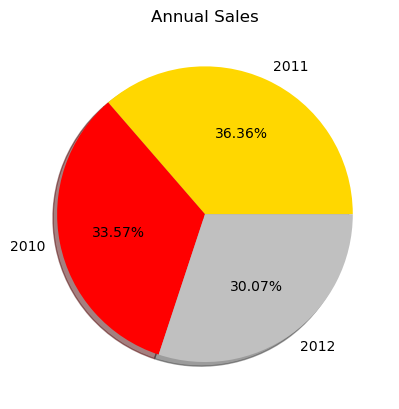

In [84]:
plt.pie(df['Year'].value_counts().values,labels =df['Year'].value_counts().index,
       autopct='%1.2f%%',shadow=True,colors=['gold','red',"silver"])
plt.title('Annual Sales')
plt.show()

Year 2011 has highest sales followed by 2010 and 2012.

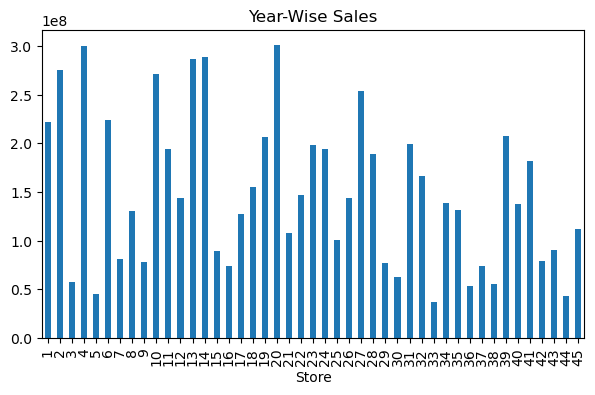

In [85]:
plt.figure(figsize=(7,4))

df.groupby('Store')['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Year-Wise Sales')

plt.show()

Store number 4 and 20 have highest weekly sales

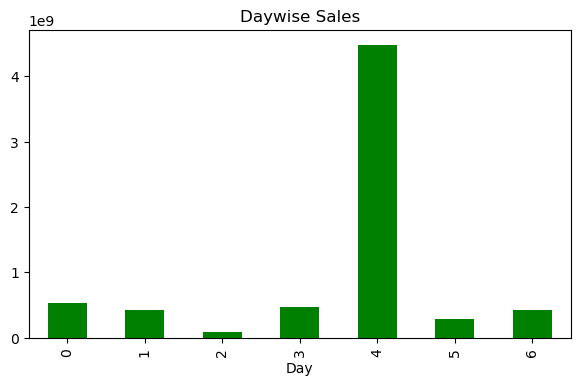

In [86]:
plt.figure(figsize=(7,4))

df.groupby(['Day'])['Weekly_Sales'].sum().plot(kind='bar',color='Green')
plt.title('Daywise Sales')

plt.show()

Thursday has maximum sales in a weeek.

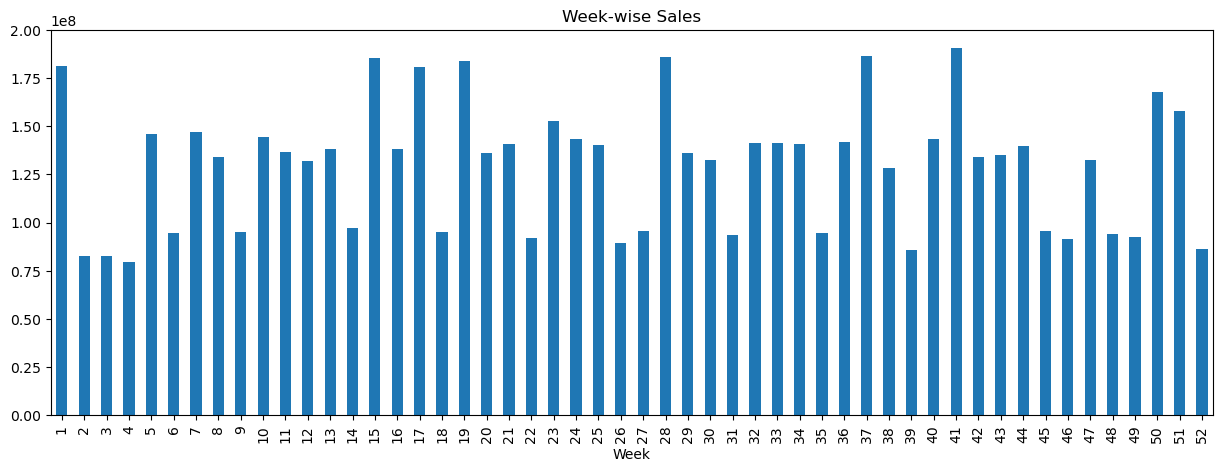

In [87]:
plt.figure(figsize=(15,5))

df.groupby(['Week'])['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Week-wise Sales')

plt.show()

41st week has highest sale in a year

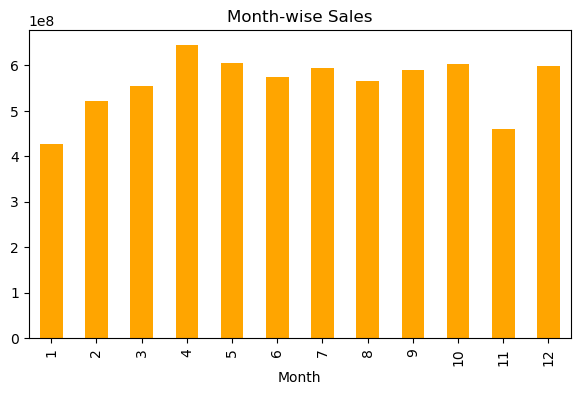

In [88]:
plt.figure(figsize=(7,4))

df.groupby('Month')['Weekly_Sales'].sum().plot(kind='bar',color='Orange')
plt.title('Month-wise Sales')

plt.show()

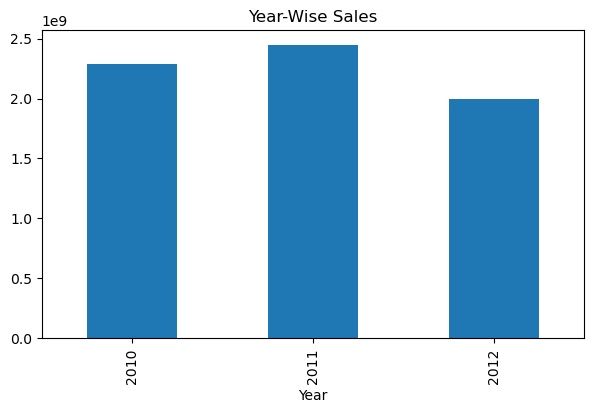

In [89]:
plt.figure(figsize=(7,4))

df.groupby('Year')['Weekly_Sales'].sum().plot(kind='bar')
plt.title('Year-Wise Sales')

plt.show()

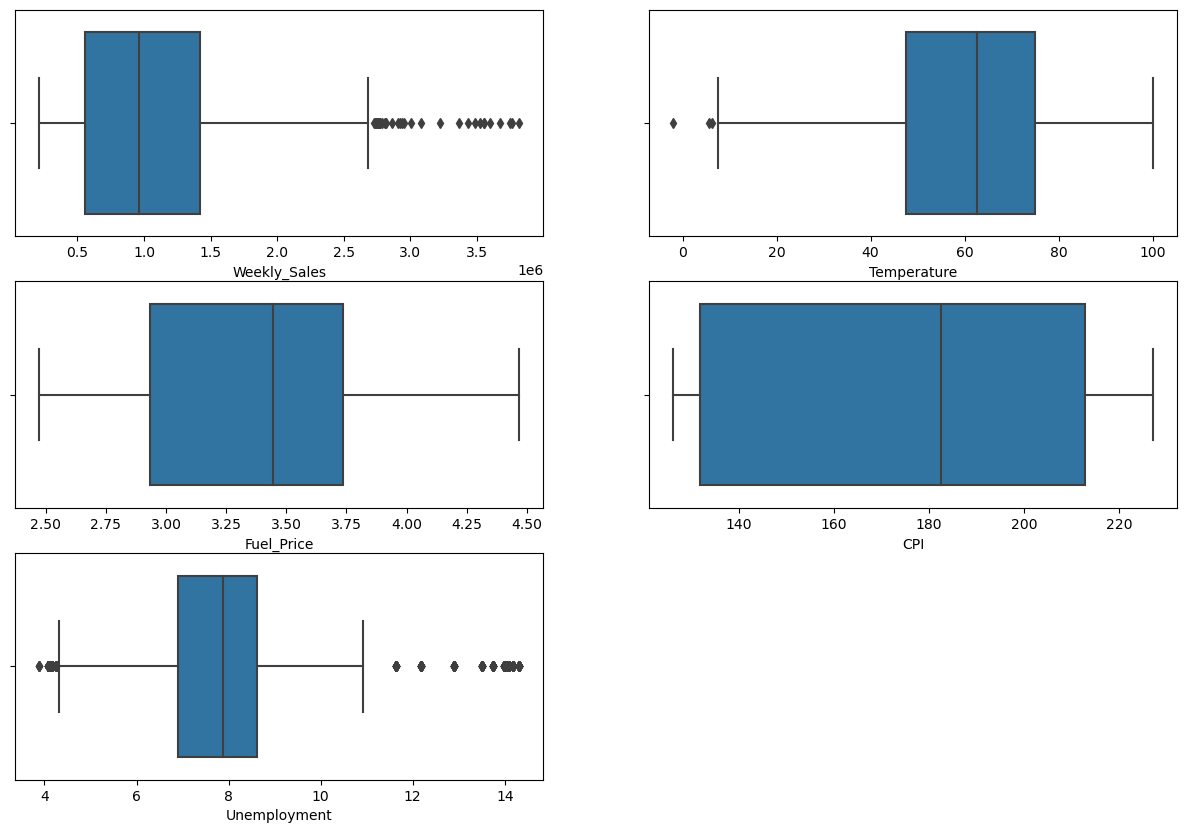

In [90]:
#checking outliers with the Boxplot

n = 1
cols =["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"]
plt.figure(figsize=(15,10))
for i in cols:
        if n<=5:
            plt.subplot(3,2,n);
            n+=1
            sns.boxplot(x = df[i])
            plt.xlabel(i)

In [91]:
l = ["Weekly_Sales","Temperature","Unemployment"]
def outlier_removal(l):
    for i in l:
        Q1  = df[i].quantile(0.25)
        Q3  = df[i].quantile(0.75)
        IQR = Q3-Q1
        Uper = Q3+1.5*IQR
        lower = Q1-1.5*IQR
        df[i]  = np.where(df[i]>Uper,Uper,(np.where(df[i]<lower,lower,df[i])))
outlier_removal(l)

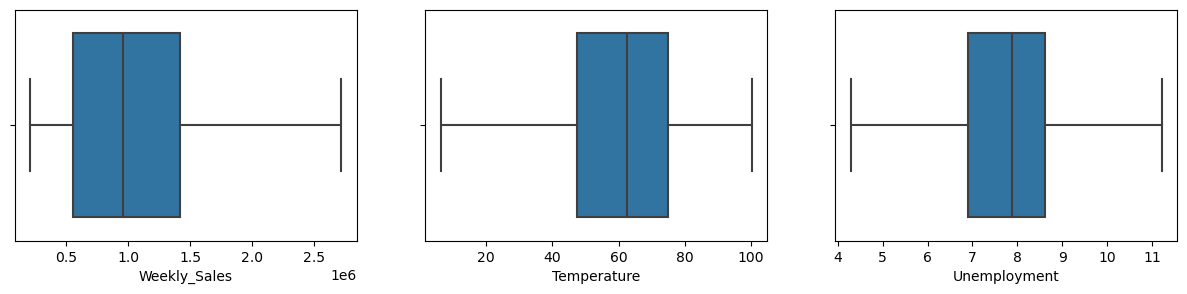

In [92]:
n = 1
cols =["Weekly_Sales","Temperature","Unemployment"]
plt.figure(figsize=(15,3))
for i in cols:
        if n<=3:
            plt.subplot(1,3,n);
            n+=1
            sns.boxplot(x = df[i])
            plt.xlabel(i)4

In [93]:
df2 = df.copy()
df2.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Week,Month,Year
0,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,7,2,2010
1,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,18,5,2010
2,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,48,12,2010
3,1,1439541.59,0,57.79,2.667,211.380643,8.106,4,48,12,2010
4,1,1472515.79,0,54.58,2.720,211.215635,8.106,4,11,3,2010


In [94]:
days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5: 'Friday',6:'Saturday'}
df2['Day'] = df2['Day'].map(days)
months={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'Novemenber',12:'December'}
df2['Month']= df2['Month'].map(months)
df2.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Week,Month,Year
0,1,1611968.17,0,39.93,2.514,211.289143,8.106,Thursday,7,February,2010
1,1,1554806.68,0,46.50,2.625,211.350143,8.106,Sunday,18,May,2010
2,1,1641957.44,1,38.51,2.548,211.242170,8.106,Wednesday,48,December,2010
3,1,1439541.59,0,57.79,2.667,211.380643,8.106,Thursday,48,December,2010
4,1,1472515.79,0,54.58,2.720,211.215635,8.106,Thursday,11,March,2010


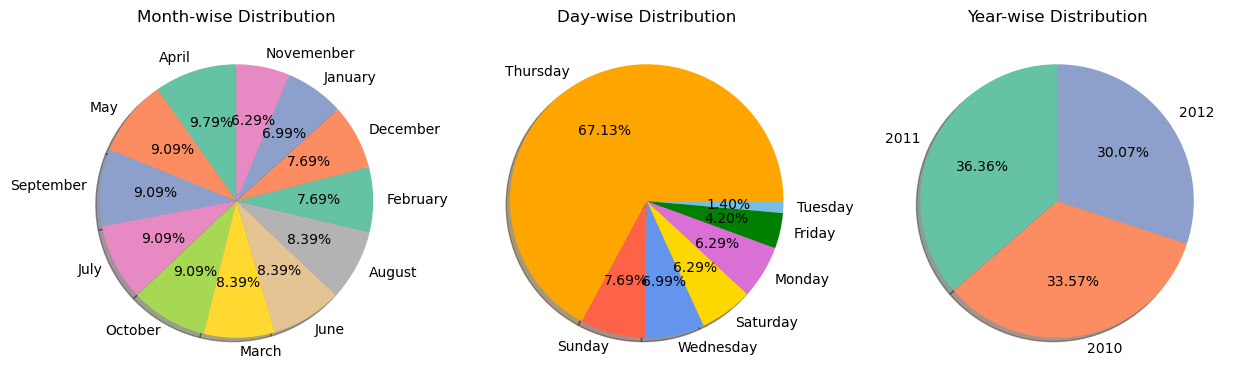

In [95]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 2)
plt.pie(df2['Day'].value_counts().values, labels =df2['Day'].value_counts().index,
autopct = '%1.2f%%', shadow=True,colors=["Orange",'tomato', 'cornflowerblue', 'gold', 'orchid', 'green',"#77BFE2"]) 
plt.title('Day-wise Distribution')
plt.grid()

plt.subplot(1, 3, 1)
plt.pie(df2['Month'].value_counts().values, labels =df2['Month'].value_counts().index,
autopct = '%1.2f%%',startangle=90, shadow=True,colors=sns.color_palette('Set2'))
plt.title('Month-wise Distribution')
plt.grid()

plt.subplot(1, 3, 3)
df3 = df2.groupby('Holiday_Flag')['Weekly_Sales'].sum().reset_index()
plt.pie(df2['Year'].value_counts().values, labels =df2['Year'].value_counts().index,
autopct = '%1.2f%%',startangle=90, shadow=True,colors=sns.color_palette('Set2'),labeldistance=1.1)  
plt.title('Year-wise Distribution')
plt.grid()


plt.show()

<Figure size 1500x1200 with 0 Axes>

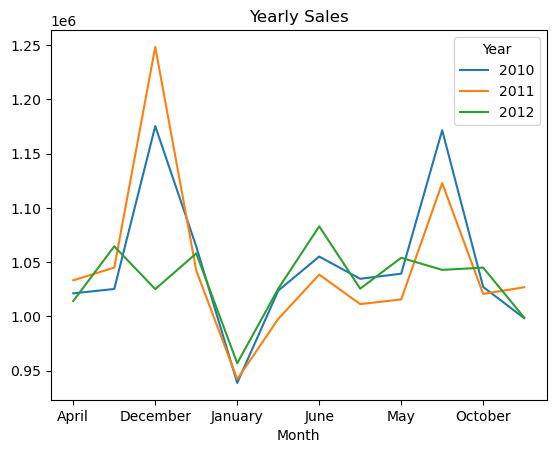

In [96]:
plt.figure(figsize=(15,12))
monthly_sales = pd.pivot_table(df2, index = "Month", columns = "Year", values = "Weekly_Sales")
monthly_sales.plot()
plt.title('Yearly Sales')
plt.show()

In [97]:
print('Minimum Sales in the Walmart: ',df2.groupby('Store')['Weekly_Sales'].sum().min())
print('Maximum Sales in the Walmart: ',df2.groupby('Store')['Weekly_Sales'].sum().max())

Minimum Sales in the Walmart:  37160221.96
Maximum Sales in the Walmart:  299066335.2575


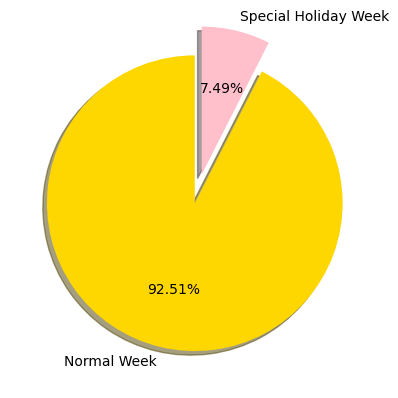

In [98]:
df3 = df2.groupby('Holiday_Flag')['Weekly_Sales'].sum().reset_index()
plt.pie(df3['Weekly_Sales'],labels= ['Normal Week','Special Holiday Week'],
autopct='%1.2f%%',startangle=90,explode=[0,0.2],shadow=True,colors=['gold','pink'])
plt.show()

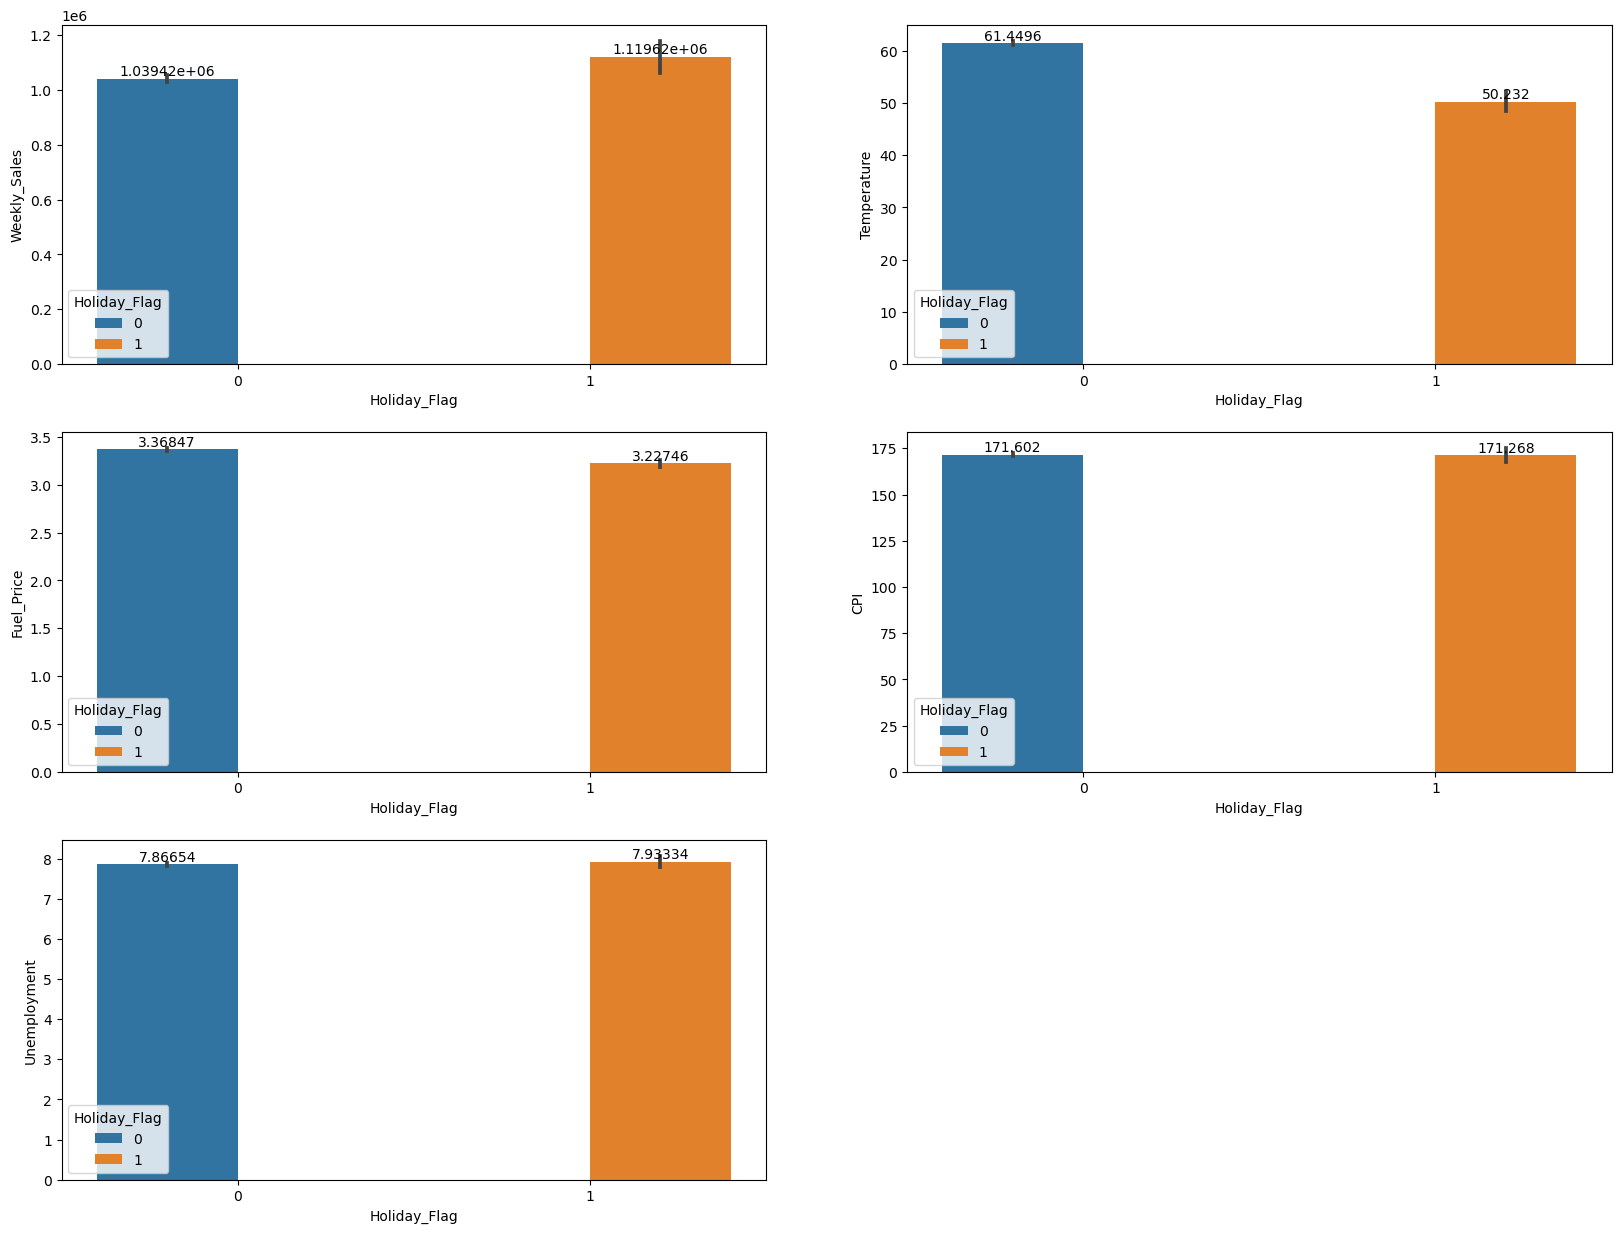

In [99]:
from numpy import mean
t = 1
plt.figure(figsize=(20,15))
for i in ["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment"]:
        if t<=5:
            plt.subplot(3,2,t)
            ax = sns.barplot(data = df2 , x = "Holiday_Flag" ,y = i  , hue = df.Holiday_Flag ,estimator=mean);
            t+=1
            
            for i in ax.containers:     #to set a label on top of the bars.
                ax.bar_label(i,)

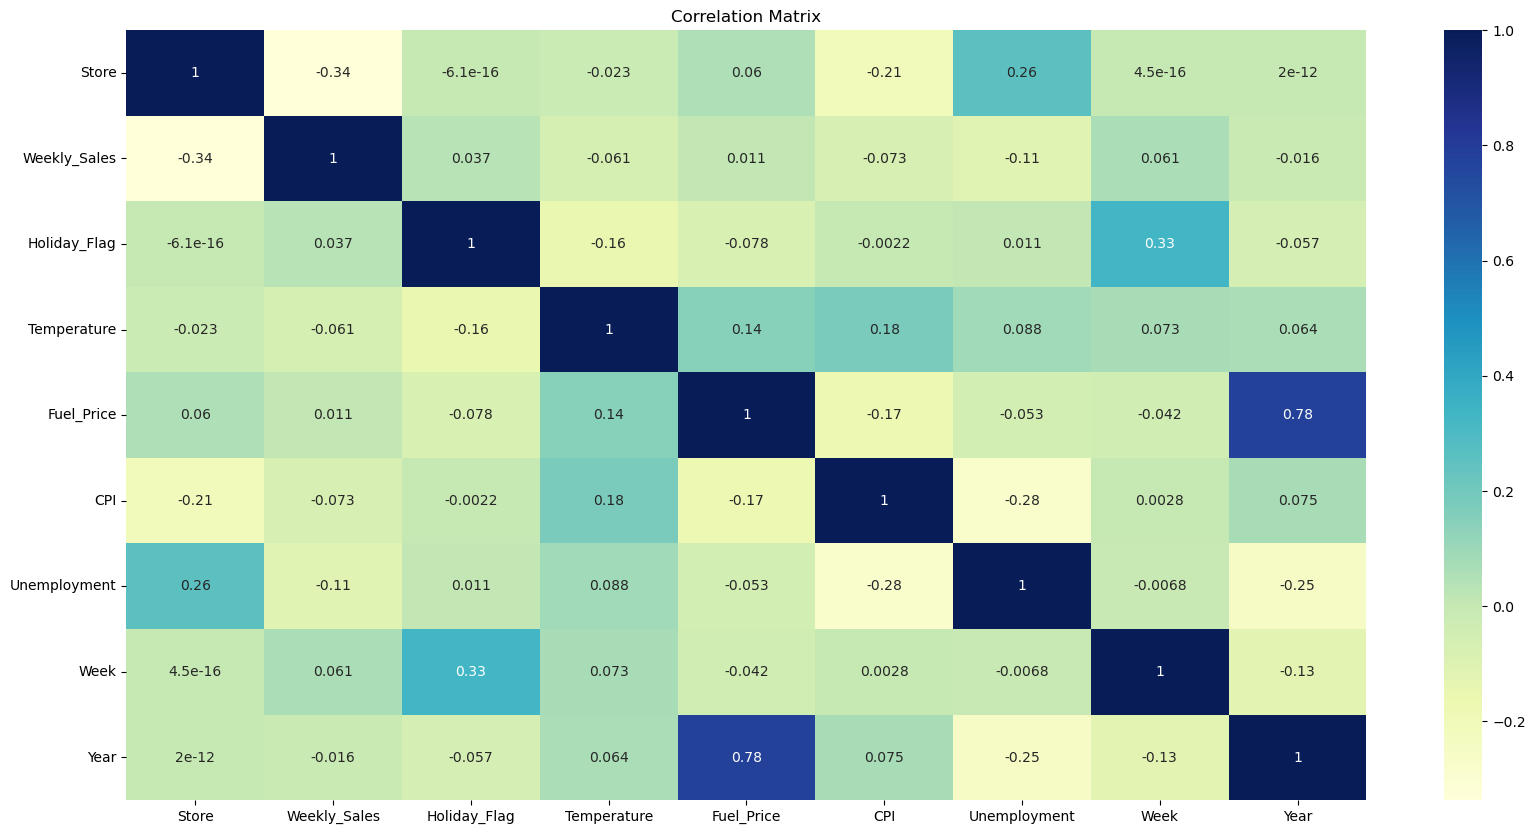

In [92]:
plt.figure(figsize = (20,10))
sns.heatmap(df2.corr(),annot=True,cmap ="YlGnBu")
plt.title('Correlation Matrix')
plt.show()

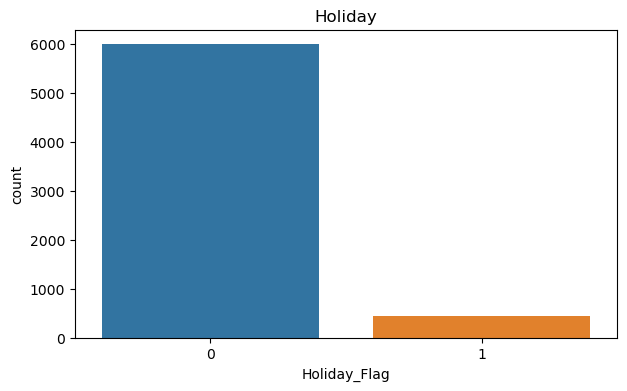

In [101]:
plt.figure(figsize=(7,4))

sns.countplot(x= df2.Holiday_Flag)
plt.title('Holiday')

plt.show()

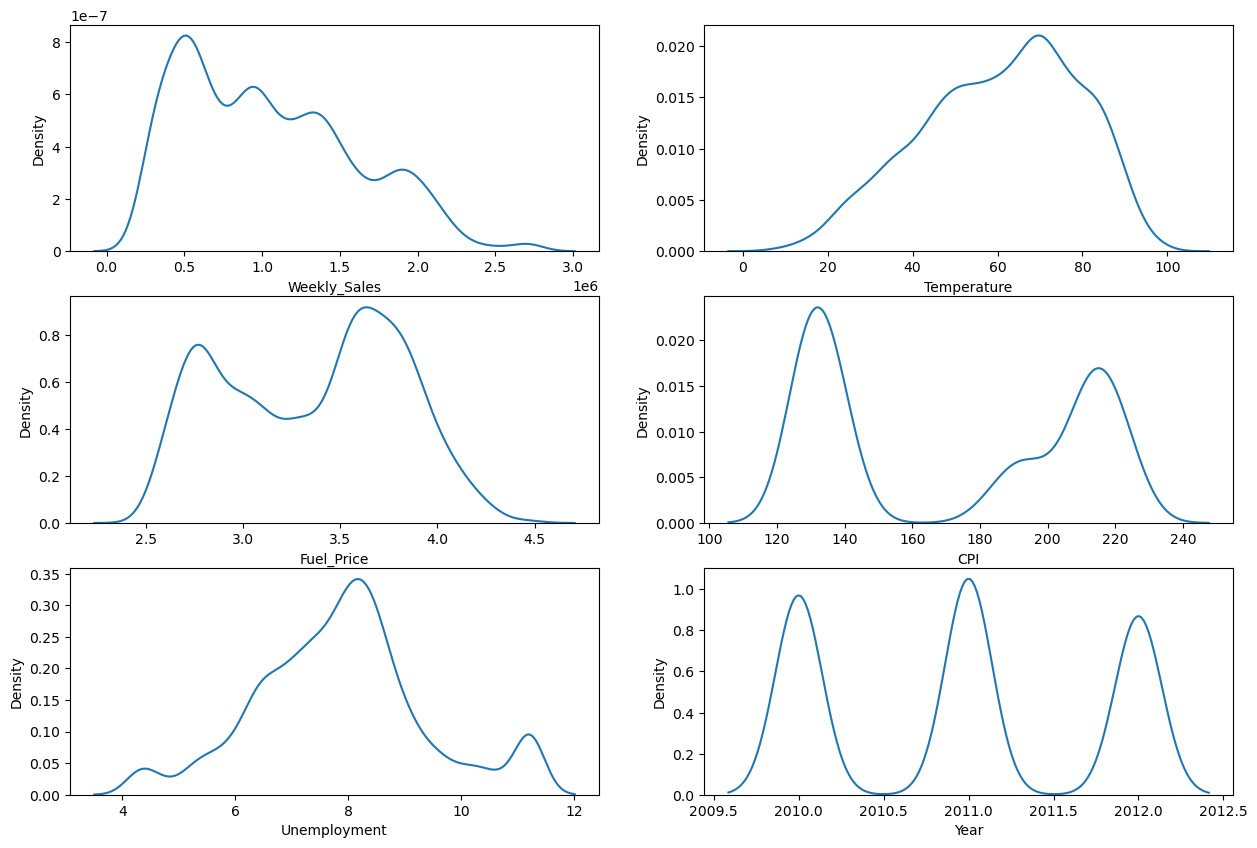

In [102]:
n = 1
plt.figure(figsize=(15,10))
for i in ['Weekly_Sales','Temperature', 'Fuel_Price','CPI', 'Unemployment','Year']:
        if n<=6:
            plt.subplot(3,2,n);
            n+=1
            sns.kdeplot(x = df2[i])
            plt.xlabel(i)

## Modelling

In [103]:
x = df.drop(['Weekly_Sales'],axis=1)
y = df['Weekly_Sales']

In [104]:
from sklearn.preprocessing import StandardScaler  
st = StandardScaler()
x_scaled = st.fit_transform(x)

In [105]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.2,random_state= 42)

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [110]:
def model(y_test, y_train, x_test, x_train, model):
    model_obj = None
    if model == "Linear Regression":
        model_obj = LinearRegression()
    elif model == "Random Forest Regressor":
        model_obj = RandomForestRegressor()
    elif model == "Decision Tree Regressor":
        model_obj = DecisionTreeRegressor()
    elif model == "K-Nearest Neighbors Regressor":
        model_obj = KNeighborsRegressor()
    else:
        print("Invalid model specified.")
        return
    
    model_obj.fit(x_train, y_train)
    y_pred = model_obj.predict(x_test)
    print("-----------------")
    print(model)
    print("-----------------")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"R2 Score: {r2_score(y_test, y_pred)*100:.2f}%")

# Example usage
model(y_test, y_train, x_test, x_train, "Linear Regression")
model(y_test, y_train, x_test, x_train, "Random Forest Regressor")
model(y_test, y_train, x_test, x_train, "Decision Tree Regressor")
model(y_test, y_train, x_test, x_train, "K-Nearest Neighbors Regressor")


-----------------
Linear Regression
-----------------
MSE: 269916386094.22076
MAE: 434364.0092369545
R2 Score: 15.20%
-----------------
Random Forest Regressor
-----------------
MSE: 16211364533.851496
MAE: 68405.23526000389
R2 Score: 94.91%
-----------------
Decision Tree Regressor
-----------------
MSE: 24098495946.959587
MAE: 83617.40617327117
R2 Score: 92.43%
-----------------
K-Nearest Neighbors Regressor
-----------------
MSE: 202935291104.8588
MAE: 340144.16261810414
R2 Score: 36.25%


Random Forest Regressor gives 95% accurate Walmart Sales Prediction.

In [112]:
#exporting the data into json form

In [113]:
df.to_json('walmart_data.json', orient='records')

In [114]:
import os
print(os.getcwd())

C:\Users\Admin


In [115]:
df.to_csv('data.csv', index=False)